In [18]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import INVARIANT_MEMORY
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_dirichlet_samples, plot_confusion_matrix

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [6]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [33]:
def rem_params_prior(**args):
    """
    Samples from the prior of the REM model theta = (g,u,c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=0.0001, high=1.0), # g
        np.random.uniform(low=0.0001, high=1.0), # u
        np.random.uniform(low=0.0001, high=1.0)  # c
    ])
        
    return theta


def bcdmem_params_prior(**args):
    """
    Samples from the prior of the BCDMEM model theta = (g,u,c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=0.0001, high=1.0),  # r
        np.random.uniform(low=0.0001, high=1.0),  # d
        np.random.uniform(low=0.0001, high=1.0)   # p
    ])
        
    return theta


def sdt_params_prior(**args):
    """
    Samples from the prior of the SDT model theta = (c,d,s)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=-10.0, high=10.0), # c
        np.random.uniform(low=0.0, high=10.0),   # d
        np.random.uniform(low=0.01, high=10.0)   # s
    ])
    
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [93]:
def rem_model(params, N_tot=50, ratio_sd=0.5, w=20):
    """
    Generates observed responses from the REM model.
    Code is based on Montenegro, Myung, and Pitt (2015).
    # pars:[g,u,c]
    # g: Environmental Base Rate
    # u: Feature Copying
    # c: Correct Feature Copying
    """
    
    # Extract params
    g, u, c = params
    
    # Prepare a vector of simulated responses
    # Column 1 - responses (0 - old, 1 - new)
    # Column 2 - true values (0 - old, 1 - new)
    x = np.zeros((N_tot, 2))
    
    # Compute number of study and number of distractor items
    N_s = int(N_tot * ratio_sd)
    N_d = N_tot - N_d
    
    # --- Feature generation --- #
    # Generate feature matrix
    W = np.random.geometric(g, size=(N_tot, w))
    
    # Extract a study feature matrix from all features
    idx = np.random.permutation(N_tot)
    idx_s = idx[:N_s]
    idx_d = idx[N_s:]
    Ws = W[idx_s, :]
    
    # --- Memory storage --- #
    # Attention to feature with probability u - otherwise feature is 0
    mask_u = np.random.binomial(1, u, size=(N_s, w))
    Ws_stored = Ws * mask_u
    
    # Imperfect 'copy' of attended features
    mask_c = np.random.binomial(1, (1-c), size=(N_s, w))
    mask_attended = mask_c & mask_u
    Ws_stored = np.where(mask_attended, np.random.geometric(g, size=(N_s, w)), Ws_stored)
    
    # --- Retrieval from memory --- #
    # Highly vectorized - perform pairwise matching for all items with broadcasting
    non_zero_mismatch = ((Ws_stored != W[:, np.newaxis, :]) & (Ws_stored != 0)) & (W[:, np.newaxis, :] != 0)
    non_zero_match = (Ws_stored == W[:, np.newaxis, :]) & (Ws_stored != 0)
    
    # Compute non zero non matching contribution
    beta_a = np.log(1 - c)
    na = beta_a * np.sum(non_zero_mismatch, axis=-1)
    
    # Compute non zero matching contribution
    mi = np.where(non_zero_match, np.log( (c + (1 - c) * g * ((1 - g) ** (Ws_stored-1))) /
                                          (g * ((1 - g) ** (Ws_stored - 1))) ), 
                  0) 
    
    mi = np.sum(mi, axis=-1)
    
    # Compute decision rule (0 - old, 1 - new) and true values (0 - old, 1 - new)
    phi = np.mean(np.exp(na + mi), axis=-1)
    
    # Phi > 1 => old (0), Phi < 1 => new (1)
    x[phi < 1, 0] = 1
    # Distractor => 1, otherwise => old (0) 
    x[idx_d, 1] = 1

    return x


def compute_n_ij(y,x):
    # x: reinstated context vector
    # y: retrieved context vector
    # return: matching n00, n01, n10, n11
    m = np.array([x,y]).T
    n00 = np.sum(np.prod(m==[0,0],axis=1))
    n01 = np.sum(np.prod(m==[0,1],axis=1))
    n10 = np.sum(np.prod(m==[1,0],axis=1))
    n11 = np.sum(np.prod(m==[1,1],axis=1))
    return np.array([n00,n01,n10,n11])

def Lratio(n,r,d,p,s):
    n00,n01,n10,n11 = n
    x1 = ((1-s+d*s*(1-r))/(1-s+d*s))**n00
    x2 = ((p*(1-s)+d*s*(r+p-r*p))/(p*(1-s)+d*s*p))**n01
    x3 = (1-r)**n10
    x4 = ((r+p-r*p)/p)**n11
    return x1*x2*x3*x4

def bcdmem_model(params, N_tot=50, ratio_sd=0.5, s=0.02, v=200):
    """
    Generates observed responses from the BCDMEM model.
    # pars:[r,d,p]
    # r: Learning Rate
    # d: Contextual Reinstatement 
    # p: Context Noise
    """
    
    
    # Extract params
    r,d,p = params
    
    # Prepare a vector of simulated responses
    # Column 1 - responses (0 - old, 1 - new)
    # Column 2 - true values (0 - old, 1 - new)
    x = np.zeros((N_tot, 2))
    
    # Compute number of study and number of distractor items
    N_s = int(N_tot * ratio_sd)
    N_d = N_tot - N_s
    
    # Study context #
    context_vector = np.random.binomial(1,s,v)
    
    # output layer #
    learned_s = np.random.binomial(1, r, size=(N_s, v)) * context_vector
    context_noise_s = np.random.binomial(1, p, size=(N_s, v))
    context_noise_d = np.random.binomial(1, p, size=(N_d, v))
    
    # Test #
    reinstated_context = np.random.binomial(1,(1-d),v) * context_vector
    retreived_context_s = context_noise_s + learned_s
    retreived_context_s[retreived_context_s==2] = 1
    retreived_context_d = context_noise_d
    
    # overlapping between reinstated (i=0,1) and retreived (j=0,1) context vectors as n(i,j) #
    retreived_context_all = np.row_stack((retreived_context_s,retreived_context_d))
    n_ij = np.apply_along_axis(compute_n_ij, axis=1, arr=retreived_context_all, x=reinstated_context)
    
    # Decision Rule #
    D = np.apply_along_axis(Lratio, axis=1, arr=n_ij, r=r,d=d,p=p,s=s)
    
    # Distractor => 1, otherwise => old (0)
    x[N_s:,1] = 1
    
    # D > 1 => old (0), Phi < 1 => new (1)
    x[D < 1, 0] = 1
    
    # Shuffle items
    np.random.shuffle(x)
    
    return x


def sdt_model(params, N_tot=50, ratio_sd=0.5):
    """
    Generates observed responses from the SDT model.
    # pars:[c,d,s]
    # c: Response Bias
    # d: Discriminability 
    # s: Target strength Noise
    """
    
    # Extract params
    c,d,s = params
    
    # Prepare a vector of simulated responses
    # Column 1 - responses (0 - old, 1 - new)
    # Column 2 - true values (0 - old, 1 - new)
    x = np.zeros((N_tot, 2))
    
    # Compute number of study and number of distractor items
    N_s = int(N_tot * ratio_sd)
    N_d = N_tot - N_s
    
    # Choose which will be test and which will be distractors
    
    # Response probabilities #
    p_s = norm.cdf((0.5*d - c)/s)
    p_d = norm.cdf((-0.5*d - c))
    
    # response study items
    x_s = np.random.binomial(1,p_s,N_s)
    # response distractor items
    x_d = np.random.binomial(1,p_d,N_d)
    
    # responses: old (0), new (1)
    x[:,0] = 1 - np.r_[(x_s, x_d)]
    
    # Distractor => 1, otherwise => old (0)
    x[N_s:,1] = 1
    np.random.shuffle(x)
    
    return x

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [45]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [46]:
#--- Training hyperparameters ---#
ckpt_file = "memory_model_selection"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_obs = 50
n_obs_min = 20
n_obs_max = 500


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['REM', 'BCDMEM', 'SDT']
param_priors = [rem_params_prior, bcdmem_params_prior, sdt_params_prior]
forward_models = [rem_model, bcdmem_model, sdt_model]

data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max)

## Create test data

In [50]:
%%time
test_data = data_gen(n_test, n_obs=n_obs_max)

Wall time: 6.83 s


## Create model

In [52]:
model = DeepEvidentialModel(INVARIANT_DEFAULTS, n_models=len(model_names), inv_xdim=False)

## Compile model
<p>In other words, run and plot performance of untrained networks.</p>

Instructions for updating:
Colocations handled automatically by placer.


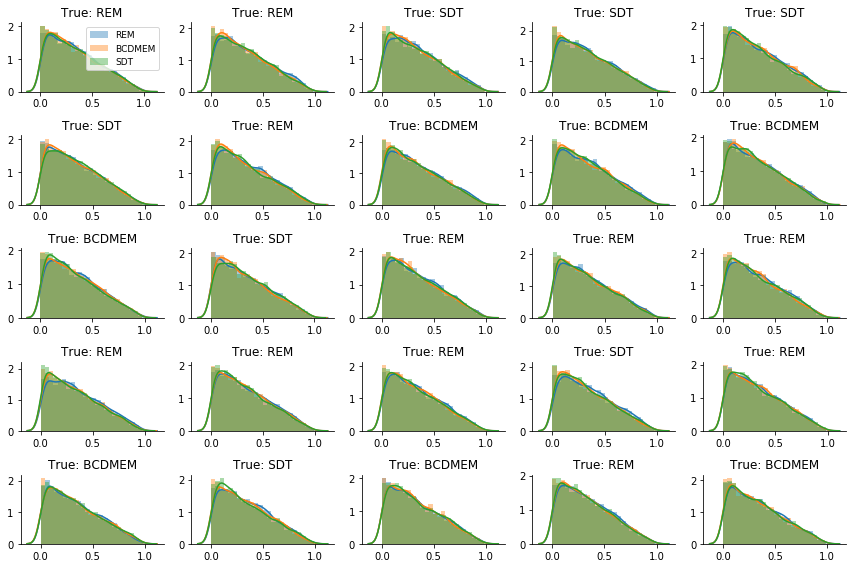

In [53]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

## Manage checkpoints

In [54]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train network

In [55]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=log_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        # Plot stuff
        plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:9], 
                       m_test=test_data['m'][:9], 
                       model_names=model_names,
                       figsize=(7, 5))

        # Store checkpoint
        manager.save()

ValueError: could not broadcast input array from shape (62) into shape (63)

# Validate evidential network

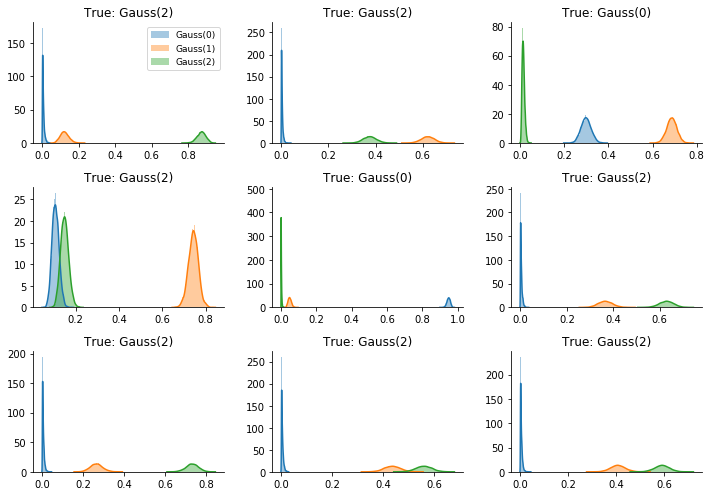

In [178]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:9], 
                       m_test=test_data['m'][:9], 
                       model_names=model_names,
                       figsize=(10, 7))

In [ ]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)